# Simulate acoustic wave propagation with multiple domains


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook shows the functionality to perform acoustic simulations when multiple domains are present.

## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


In [4]:
optimus.global_parameters.print()


Verbosity parameter: False

Linear algebra parameters:
 Tolerance: 1e-05
 Maximum number of iterations: 1000
 Number of iterations before restart: 1000

Preconditioning parameters:
 OSRC preconditioner.
  Number of Padé expansion terms: 4
  Branch cut angle for Padé series: 1.0471975511965976
  Wavenumber: int
  Damped wavenumber: None

Postprocessing parameters:
 Potential operator assembly type is:  h-matrix
 H-matrix epsilon for postprocessing operators: 1e-08
 H-matrix maximum rank for postprocessing operators: 10000
 H-matrix maximum block size for postprocessing operators: 10000


## Specify the physical settings for the simulation

Let us consider two spherical objects embedded in an unbounded region of water. One of the domains consists of fat and the other of cortical bone. The incident plane wave has a frequency of 100 kHz and the two spheres have a radius of 7 and 5 mm, respectively.

In [5]:
frequency = 2e3
source = optimus.source.create_planewave(frequency, direction=(1,0,0))

In [6]:
radii = (7e-3, 5e-3)
origins = ((-10e-3,0,0), (10e-3,0,0))
meshwidth = 2e-3

In [7]:
geometry_left = optimus.geometry.shapes.Sphere(radius=radii[0], origin=origins[0], element_size=meshwidth)
geometry_right = optimus.geometry.shapes.Sphere(radius=radii[1], origin=origins[1], element_size=meshwidth)
geometries = (geometry_left, geometry_right)

In [8]:
geometries[0].label

'sphere'

A list of materials can be loaded at once.

In [9]:
material_ext = optimus.material.load_material('water')
materials_int = optimus.material.load_material(('fat', 'bone (cortical)'))
material_left, material_right = materials_int

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. The model with default settings needs the physical parameters as input. The interior domains are specified as a tuple or list of the geometries and the materials, while the exterior medium needs to be specified separately.

In [10]:
model = optimus.model.create_acoustic_model(source, geometries, material_ext, materials_int, 
                                            formulation='pmchwt',
                                            preconditioner='osrc')

Solving the model requires the GMRES algorithm to solve the system of boundary integral equations. This can be computationally expensive depending on the grid resolution.

In [11]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [12]:
import numpy as np
import bempp.api
from matplotlib import pylab as plt

In [13]:
# Create a visualisation grid
Nx = 61
Ny = 71
xmin, xmax, ymin, ymax = [20e-3, 30e-3, -15e-3, 20e-3]
zmin, zmax = [-1e-3,1e-3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j, zmin:zmax:Nx * 1j]
# points = np.vstack((plot_grid[0].ravel(),
#                     plot_grid[1].ravel(),
#                     zval*np.ones(plot_grid[0].size)))
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    plot_grid[2].ravel()))

In [14]:
points

array([[ 0.02      ,  0.02      ,  0.02      , ...,  0.03      ,
         0.03      ,  0.03      ],
       [-0.015     , -0.015     , -0.015     , ...,  0.02      ,
         0.02      ,  0.02      ],
       [-0.001     , -0.00096667, -0.00093333, ...,  0.00093333,
         0.00096667,  0.001     ]])

In [15]:
pp_2d = optimus.postprocess.PostProcess_2D(model)

In [16]:
pp_2d.create_computational_grid(resolution=[Nx,Ny], plane_axes=[0,1], 
                             plane_offset=0, bounding_box=[-20e-3, 30e-3, -15e-3, 20e-3])


 Identifying the exterior and interior points Started at:  Sun, 26 Jun 2022 22:40:05
Element groups are:
[0]
Time to complete solid angle field parallelisation:  0.9745001792907715
Element groups are:
[0]
Time to complete solid angle field parallelisation:  1.0138204097747803

 Identifying the exterior and interior points Finished... Duration in secs:  2.062732696533203


../optimus/postprocess/concave_hull.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


In [17]:
pp_2d.points

array([[-0.02  , -0.02  , -0.02  , ...,  0.03  ,  0.03  ,  0.03  ],
       [-0.015 , -0.0145, -0.014 , ...,  0.019 ,  0.0195,  0.02  ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

In [18]:
pp_2d.index_interior[1].any()

True

In [19]:
pp_2d.index_exterior.any()

True

In [20]:
pp_2d.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Sun, 26 Jun 2022 22:40:07
Calculating the fields of Domain 1
(3, 363) (4331,) (8.725510125840678+0.005104062371778364j) <optimus.material.common.Material object at 0x7f4a9ecd1ef0>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  0.8836236000061035
Calculating the fields of Domain 2
(3, 181) (4331,) (3.5752151804793613+0.109106j) <optimus.material.common.Material object at 0x7f4a9ece9c18>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  1.2772419452667236

 Calculating the incident field Started at:  Sun, 26 Jun 2022 22:40:08

 Calculating the incident field Finished... Duration in secs:  0.011407852172851562


In [21]:
pp_2d.total_field.shape

(4331,)

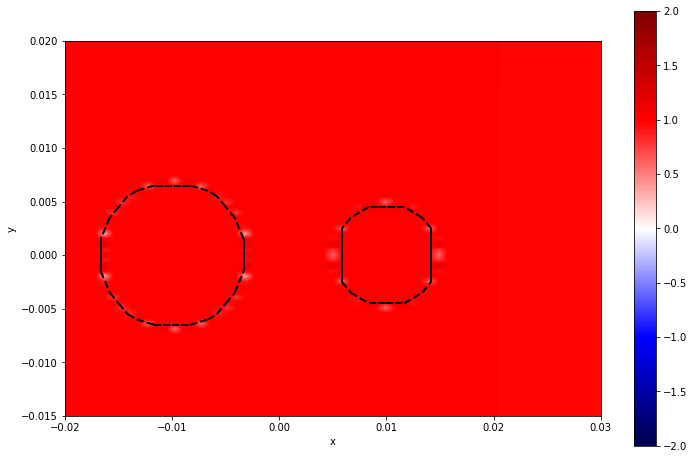

In [42]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.real(pp_2d.total_field_reshaped), extent=pp_2d.bounding_box, clim=(-2,2), cmap='seismic', 
           interpolation='bilinear')

for i, j in pp_2d.domains_edges:
    plt.plot(i, j, color = 'black', linestyle='dashed' ,linewidth=2)
    
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [23]:
# ppu_2d = optimus.postprocess.PostProcess_UserDefined(model,verbose=True)

In [24]:
# ppu_2d.create_computational_grid(resolution=[Nx,Ny],user_points=points)

In [25]:
# ppu_2d.compute_fields()

In [26]:
# fig = plt.figure(figsize=(12, 8))
# plt.imshow(np.real(ppu_2d.total_field_reshaped), extent=(xmin, xmax, ymin, ymax), clim=(-2,2), cmap='seismic', 
#            interpolation='bilinear')
# theta = np.linspace(0, 2*np.pi, 100)
    
# plt.xlabel('x')
# plt.ylabel('y')
# plt.colorbar()
# plt.show()

In [27]:
ppu_3d = optimus.postprocess.PostProcess_UserDefined(model,verbose=True)

In [28]:
ppu_3d.create_computational_grid(user_points=points)


 Identifying the exterior and interior points Started at:  Sun, 26 Jun 2022 22:40:09
Element groups are:
[0]


../optimus/postprocess/method.py:213: RuntimeWarning: The user-defined points will be used for field calculations.
  RuntimeWarning,


Time to complete solid angle field parallelisation:  5.412390947341919
Element groups are:
[0]
Time to complete solid angle field parallelisation:  5.34433650970459

 Identifying the exterior and interior points Finished... Duration in secs:  13.942238092422485


In [29]:
ppu_3d.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Sun, 26 Jun 2022 22:40:23
Calculating the fields of Domain 1
(3, 0) (264191,) (8.725510125840678+0.005104062371778364j) <optimus.material.common.Material object at 0x7f4a9ecd1ef0>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  34.225127935409546
Calculating the fields of Domain 2
(3, 0) (264191,) (3.5752151804793613+0.109106j) <optimus.material.common.Material object at 0x7f4a9ece9c18>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  61.90796875953674

 Calculating the incident field Started at:  Sun, 26 Jun 2022 22:41:25

 Calculating the incident field Finished... Duration in secs:  0.04464364051818848


In [35]:
ppu_3d.total_field

array([0.98552338+0.1689753j , 0.98552336+0.16897539j,
       0.98552334+0.16897548j, ..., 0.96775276+0.2517088j ,
       0.96775277+0.25170879j, 0.96775277+0.25170877j])

In [38]:
pp_2d.total_field

array([0.98568447-0.1687784j , 0.98568674-0.16877144j,
       0.98568917-0.16876359j, ..., 0.96774936+0.25172097j,
       0.96775105+0.25171489j, 0.96775269+0.25170905j])

In [30]:
pp_3d = optimus.postprocess.PostProcess_3D(model,verbose=True)

In [31]:
pp_3d.create_computational_grid(plane_offset=0.0)


 Identifying the exterior and interior points Started at:  Sun, 26 Jun 2022 22:41:31
Element groups are:
[0]
Time to complete solid angle field parallelisation:  5.345489263534546
Element groups are:
[0]
Time to complete solid angle field parallelisation:  5.752026081085205

 Identifying the exterior and interior points Finished... Duration in secs:  11.94873833656311


In [32]:
pp_3d.index_interior[1].any()

True

In [33]:
pp_3d.compute_fields()


 Calculating the interior and exterior potential operators Started at:  Sun, 26 Jun 2022 22:41:43
Calculating the fields of Domain 1
(3, 20130) (60520,) (8.725510125840678+0.005104062371778364j) <optimus.material.common.Material object at 0x7f4a9ecd1ef0>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  7.982728719711304
Calculating the fields of Domain 2
(3, 9981) (60520,) (3.5752151804793613+0.109106j) <optimus.material.common.Material object at 0x7f4a9ece9c18>

 Calculating the interior and exterior potential operators Finished... Duration in secs:  13.720355749130249

 Calculating the incident field Started at:  Sun, 26 Jun 2022 22:41:57

 Calculating the incident field Finished... Duration in secs:  0.015495538711547852


In [34]:
fig = plt.figure(figsize=(12, 8))
pp_3d_ptot_plot = np.flipud(pp_3d.total_field.reshape(pp_3d.resolution).T)
plt.imshow(np.real(pp_3d_ptot_plot), extent=(xmin, xmax, ymin, ymax), clim=(-2,2), cmap='seismic', 
           interpolation='bilinear')
    
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

ValueError: cannot reshape array of size 60520 into shape (141,141)

<Figure size 864x576 with 0 Axes>

In [ ]:
np.isnan(pp_3d.total_field).any()